In [1]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd
import pandas as pd
import numpy as np

from qubx.data.helpers import loader
from qubx.data.readers import AsFundingPayments
from qubx.core.basics import FundingPayment
from qubx.data.helpers import ReaderRegistry
from qubx.core.basics import DataType
from qubx.core.interfaces import IStrategy, IStrategyContext, MarketEvent, Signal, IStrategyInitializer
from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.63
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
# ld = loader("BINANCE.UM", "1h", source="mqdb::quantlab")
ld = ReaderRegistry.get("mqdb::quantlab")

In [3]:
fd = ld.read(
    "BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-10",
    transform=AsFundingPayments(),
    data_type="funding_payment",
)

In [4]:

class TestStg(IStrategy):
    enable_funding_payments = True

    _payments = []

    def on_init(self, initializer: IStrategyInitializer):
        initializer.set_base_subscription(DataType.OHLC["4h"])
        if self.enable_funding_payments:
            initializer.subscribe(DataType.FUNDING_PAYMENT)
    
    def on_start(self, ctx: IStrategyContext):
        q = ctx.quote(ctx.instruments[0])
        if q is None:
            return
        amount = ctx.get_total_capital() / q.mid_price()
        ctx.trade(ctx.instruments[0], amount)

    def on_market_data(self, ctx: IStrategyContext, event: MarketEvent):
        data = event.data
        if isinstance(data, FundingPayment):
            self._payments.append(data)


r = simulate(
    strategies={
        "funding": (stg:=TestStg(enable_funding_payments=True)),
        # "no_funding": TestStg(enable_funding_payments=False),
    },
    data={
        "ohlc(4h)": ld,
        "funding_payment": ld,
    },
    capital=1000,
    instruments=["BINANCE.UM:TRUMPUSDT"],
    commissions=None,
    start="2025-03-01",
    stop="2025-07-01",
    debug="ERROR",
    n_jobs=1,
)

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Funding pnl,Execs
funding,-278.463,-0.623,-0.01,-0.0,59.706,817.511,-0.021,-1.128,0.994,0.0,123.151,-0.004,0.0,3.57,1.0


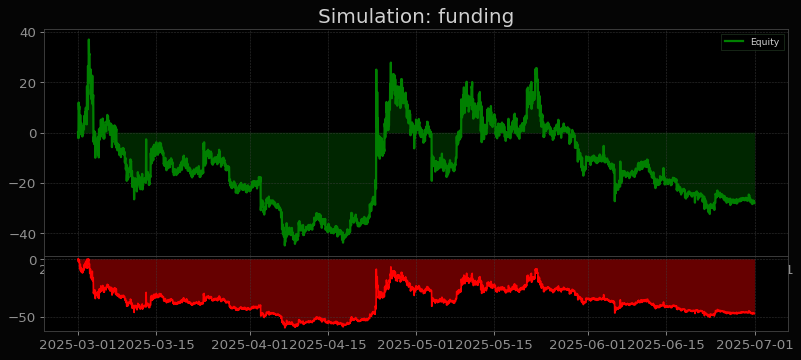

In [6]:
tearsheet(r)

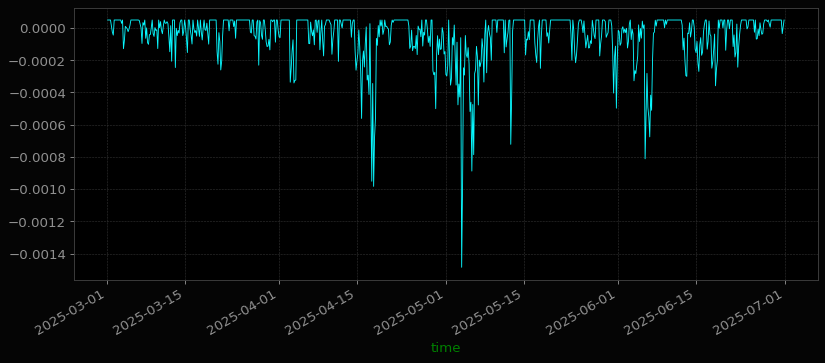

In [48]:
# transform stg._payments to pandas dataframe
df = pd.DataFrame(stg._payments)
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df.funding_rate.plot();